In [13]:
import pennylane as qml 
from torch.nn import functional as F
from einops import rearrange 
import torch 
from matplotlib import pyplot as plt    
from torch import nn 

class Q_Conv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int=0, num_layers: int=0, num_qubits: int=0):
        super().__init__()
        if num_qubits == 0:
            num_qubits = kernel_size**2 * in_channels
        if num_layers == 0:
            num_layers = kernel_size**2
        assert num_qubits == kernel_size**2 * in_channels, "The kernel size must be a square of the number of qubits"
        dev = qml.device("default.qubit", wires=num_qubits)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.out_channels = out_channels

        @qml.qnode(dev)
        def qnode(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(num_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(num_qubits))
            return [qml.expval(qml.PauliZ(wires=list(range(num_qubits))[-1]))]

        weight_shapes = {"weights": (num_layers, num_qubits)}

        self.qlayer_list = nn.ModuleList([qml.qnn.TorchLayer(qnode, weight_shapes) for _ in range(self.out_channels)])
        # fig, ax = qml.draw_mpl(qnode ,expansion_strategy='device')(torch.randn(num_qubits),
        #                     torch.randn(num_layers, num_qubits))
        # fig.savefig('./model.png')


    def forward(self, x):
        assert len(x.shape) == 4, "The input tensor must be 4D"
        assert x.shape[1] == self.in_channels, "The number of input channels must be equal to the in_channels"
        bs, ch, H, W = x.shape
        res = list()
        res_x = torch.zeros_like(x, device=x.device)
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        x = x.unfold(2, self.kernel_size, self.stride)
        x = x.unfold(3, self.kernel_size, self.stride)
        x = rearrange(x, 'b c h w i j -> b h w (c i j)')    
        print(f'{x.shape = }')
        for i in range(self.out_channels):
            for b in range(bs):
                for h in range(H): 
                    for w in range(W):
                        res_x[b][0][h][w] = self.qlayer_list[i](x[b][h][w])
        return res_x



In [14]:
model = Q_Conv2d(1, 1, 3, 1, 1, num_layers=4).cuda() 
img = torch.randn(16, 1, 100, 100).cuda()
logits = model(img)
logits.shape

x.shape = torch.Size([16, 100, 100, 9])


KeyboardInterrupt: 

In [ ]:
padded_img = torch.nn.functional.pad(img, (10, 10, 10, 10))
padded_img.shape

torch.Size([16, 1, 120, 120])

In [11]:
import json 
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict

In [12]:
def results(res_path: str) -> dict: 
    with open(res_path, 'r') as f: 
        data = f.read() 
    data = data.replace('test loss', '\"test_loss"')
    data = '{' + data + '}'
    data = data.replace('\'', '\"')
    data = json.loads(data)
    return data['test_loss']

In [13]:
res_path = 'logs/unet_noise/unet-0.0/test_results.txt' 
data = results(res_path)
data

{'test_ssim_loss': 0.0141,
 'test_dice_loss': 0.2513,
 'test_log_cosh_dice_loss': 0.0442,
 'test_bce_loss': 0.0326,
 'test_total_loss': 0.6377}

In [14]:
def log(res: dict, log_dct: dict) -> dict: 
    for key in log_dct.keys(): 
        res[key].append(log_dct[key])   
    return res

In [23]:
noise = [0.0, 0.1, 0.2, 0.3, 0.4]#, 0.5] 
qunet_data = defaultdict(list)
unet_data = defaultdict(list)
for n in noise: 
    unet_path = f'logs/unet_noise/unet-{n}/test_results.txt'
    qunet_path = f'logs/q_unet_noise/q_unet-{n}/test_results.txt'
    log(qunet_data, results(qunet_path))
    log(unet_data, results(unet_path))

[0.7133, 0.75, 0.776, 0.9998, 1.0849]

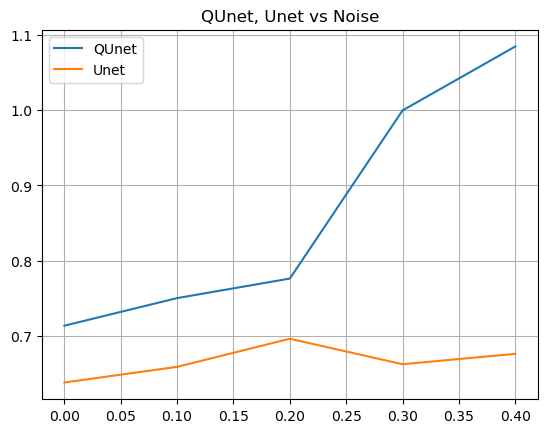

In [27]:
plt.title('QUnet, Unet vs Noise')
plt.plot(noise, qunet_data['test_total_loss'], label='QUnet')
plt.plot(noise, unet_data['test_total_loss'], label='Unet')
plt.legend()
plt.grid() 
plt.show()